# Imports and loading dataset

### Financial tweets data:
Filtered twitter data for text classification. Consists of the following columns
* `date`: The date when the tweet was posted
* `symbol`: The symbol the tweet is associated with, by using '$symbol' as the query for the search API
* `tweet`: Full text data of the tweet
* `id`: Tweet id of the tweet

We will take the test set from the previous notebook, so that we can test the predictions on data the classifier was not trained on. Also, since we will be doing a similar labelling with the previous notebook, using the dataset with the train data could lead to unreliable results.

In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

df = pd.read_csv("../input/jus-testing/test_tweets.csv", dtype={'id': 'string'})
df

,date,symbol,tweet,id,bullish
0,2021-06-02,AMWL,amwell to participate in the 42nd annual goldm...,1400019278003326979,1.0
1,2021-06-15,MRVL,great pitch shana you nailed it going long on ...,1404937455174754311,0.0
2,2021-05-18,AMC,*amc block of 17m share is said to price at $ ...,<NA>,1.0
3,2021-05-26,XOM,big day for exxon mobil : 16 board candidate a...,1397508562402746371,1.0
4,2021-06-08,SONO,$ sono brian eno premiere three hundred track ...,1402250150177804289,1.0
...,...,...,...,...,...
3333,2021-05-24,NVDA,$ nvda popped almost 3 % . someone always know...,1396823832669954058,1.0
3334,2021-05-17,NCLH,$ nclh good buy the dip ! best of cruise stock !,<NA>,1.0
3335,2021-06-08,LEDS,update : intraday max move down from alerted d...,1402264175263600643,1.0
3336,2021-06-12,BABA,$ baba vs. big tech faang the lower $ baba go ...,1403578246353014784,1.0


### Tweet financial sentiment classifier
We will also load in our trained classifier and fitted vectorizer to label these tweets. Ensure that the sklearn version is `0.24.1` since sklearn requires the model to be loaded with the same version of sklearn that the trained model was saved in. Again, we will define some utility functions to visualise the tweets

In [2]:
!pip install -q scikit-learn==0.24.1

In [3]:
from joblib import load

classifier = load("../input/financial-tweets-and-stock-prices/svm_classifier.joblib")
vectorizer = load("../input/financial-tweets-and-stock-prices/vectorizer.joblib")

In [4]:
# Print 5 sample tweets from the dataframe, along with its associated symbol
# and the link to the original tweet if the id exists
def print_tweets(df):
    sample = df.sample(n=5, random_state=41)
    for _, row in sample.iterrows():
        print(f"Symbol: {row.symbol}")
        if type(row.id) == str:
            print(f"Link: https://twitter.com/user/status/{row.id}")
        print(f"Text: {row.tweet}")
        print("==============================")  

### Labelling our tweets
Using our trained classifier, let's label our tweets based on the prediction of the classifier. A '1' represents a bullish sentiment, while a '0' represents a bearish sentiment.
<br>
While the classifier does not have a high accuracy, we will see that the labels do make sense to some degree.

In [5]:
df['bullish'] = classifier.predict(vectorizer.transform(df.tweet))

In [6]:
bullish_tweets = df.loc[df.bullish == 1]
bearish_tweets = df.loc[df.bullish == 0]

#### Some example tweets for bullish tweets

In [7]:
print_tweets(bullish_tweets)

Symbol: SPCE
Link: https://twitter.com/user/status/1396130214476931076
Text: news – virgin galactic is back in space : the company completed it first spaceflight in over two year , with v unity taking an important step toward finishing development . $ spce
Symbol: XLE
Link: https://twitter.com/user/status/1400093594476761089
Text: $ xle will print all summer .
Symbol: C
Link: https://twitter.com/user/status/1404680096485609473
Text: bounty offered : relation between matter power spectrum $ p ( k ) $ and matter angular power spectrum $ c ... # cosmology
Symbol: SU
Link: https://twitter.com/user/status/1400091906323984385
Text: $ su significant price break here .
Symbol: SPY
Link: https://twitter.com/user/status/1400098342529646595
Text: $ spy hit all time high finally


#### Some example tweets for bearish tweets

In [8]:
print_tweets(bearish_tweets)

Symbol: LPTH
Link: https://twitter.com/user/status/1401305678237646852
Text: mid candle dip from friday on $ lpth # momotwit
Symbol: CAN
Link: https://twitter.com/user/status/1402989564327718917
Text: no word for $ can , let ’ s have a moment of silence . nasdaq up almost 1 % and bitcoin just reclaimed % gain in 20 min . manipulation at it finest
Symbol: AMAT
Link: https://twitter.com/user/status/1404922102621298690
Text: $ amat applied material , inc. - top stock up 160 % from low . close : 138.64 volvsavg : 0.86 liq : $ 803m
Symbol: CRM
Link: https://twitter.com/user/status/1402262439396261897
Text: $ crm perfect back test . chart : : //
Symbol: SU
Link: https://twitter.com/user/status/1401988612233760771
Text: $ su | when investor make decision in suncor energy $ su opportunity surface ( su )


### Predicting direction of stock price movements using sentiments
Our classifier was trained by labelling each tweets based on its change in price after the tweet, which can be misleading as a single tweet doesn't impact the price of stocks greatly (usually). Thus, let us group the tweets based on its symbol and date, so that we get a group of tweets about a particular symbol on a specific date. We can then use the sentiments of this group of tweets to train a model to predict stock price movements.
<br><br>
For now, let's try just getting 2 features for each group, the number of positive tweets and the total number of tweets about the group

In [9]:
grouped_tweets = pd.DataFrame(columns=['date_symbol', 'positive_tweets', 'total_tweets'])

for date_symbol, data in df.groupby(['date', 'symbol']):
    total_tweets = len(data)
    positive_tweets = len(data.loc[data.bullish == 1])
    grouped_tweets = grouped_tweets.append({'date_symbol': date_symbol, 
                                            'positive_tweets': positive_tweets,
                                            'total_tweets': total_tweets}, ignore_index=True)

In [10]:
grouped_tweets

,date_symbol,positive_tweets,total_tweets
0,"(2021-05-10, FB)",0,1
1,"(2021-05-11, AAPL)",1,1
2,"(2021-05-11, PLTR)",1,1
3,"(2021-05-12, QQQ)",0,1
4,"(2021-05-13, CRIS)",1,1
...,...,...,...
2319,"(2021-06-16, WISH)",0,2
2320,"(2021-06-16, WMB)",0,1
2321,"(2021-06-16, WPG)",0,3
2322,"(2021-06-16, X)",0,1


We can now label these groups in the same way as we labelled our original tweets, by checking the change in price of the symbol before and after the tweet. A rise in price will be given a bullish label of '1', while a drop in price will be given a bearish label of '0'

In [11]:
from datetime import timedelta, datetime

prices_df = pd.read_csv("../input/financial-tweets-and-stock-prices/prices_data.csv")

# Last date available in prices data
max_date = datetime.strptime(prices_df['date'].max(), "%Y-%m-%d")
delta = timedelta(days=1)

# Label a tweet based on its date and symbol
# Returns a 1 if the price of the symbol increased after the date
# of tweet, and 0 if the price decreased. Returns None if the price
# data is not available
def label_tweets(symbol, date):
    # Get prices data for the corresponding symbol
    data = prices_df[prices_df["symbol"].ravel() == symbol]
    tweet_date = datetime.strptime(date, "%Y-%m-%d")
    
    # Get first date before date of tweet where prices data exist
    prev_date = tweet_date - delta
    while prev_date.strftime("%Y-%m-%d") not in data['date'].values:
        prev_date = prev_date - delta
    prev_date = prev_date.strftime("%Y-%m-%d")
    
    next_date = tweet_date
    # Get next date after tweet date where prices data exist, 
    # until exceeding last date in dataset
    while (next_date.strftime("%Y-%m-%d") not in data['date'].values) and (next_date <= max_date):
        next_date = next_date + delta
    next_date = next_date.strftime("%Y-%m-%d")
    
    date_one_data = data.loc[data['date'] == prev_date]
    date_two_data = data.loc[data['date'] == next_date]
    # Only if data from both dates exist
    if (len(date_one_data) > 0 and len(date_two_data) > 0):
        close_price_one = date_one_data.squeeze()['adjusted_close']
        close_price_two = date_two_data.squeeze()['adjusted_close']
        return 1 if (close_price_two - close_price_one >= 0) else 0
    else:
        return None

In [12]:
grouped_tweets['bullish'] = grouped_tweets.apply(
    lambda row: label_tweets(row.date_symbol[1], row.date_symbol[0]), axis=1)

grouped_tweets

,date_symbol,positive_tweets,total_tweets,bullish
0,"(2021-05-10, FB)",0,1,0
1,"(2021-05-11, AAPL)",1,1,0
2,"(2021-05-11, PLTR)",1,1,1
3,"(2021-05-12, QQQ)",0,1,0
4,"(2021-05-13, CRIS)",1,1,0
...,...,...,...,...
2319,"(2021-06-16, WISH)",0,2,0
2320,"(2021-06-16, WMB)",0,1,0
2321,"(2021-06-16, WPG)",0,3,0
2322,"(2021-06-16, X)",0,1,0


Let us drop unlabelled data due to missing prices data and visualise some differences between bullish and bearish groups

In [13]:
grouped_tweets.dropna(inplace=True)
bullish_groups = grouped_tweets.loc[grouped_tweets.bullish == 1]
bearish_groups = grouped_tweets.loc[grouped_tweets.bullish == 0]

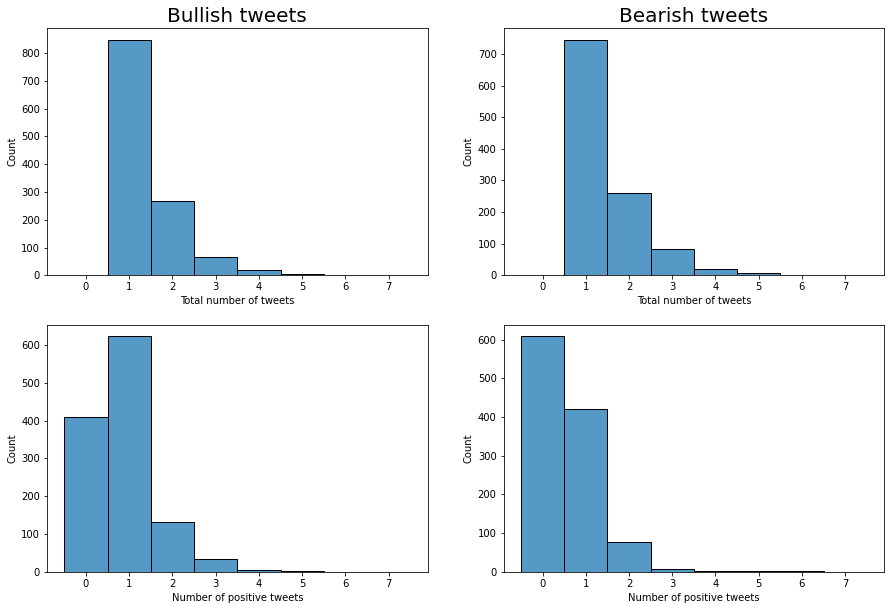

In [14]:
max_tweets = max(grouped_tweets.total_tweets.max(), grouped_tweets.positive_tweets.max())

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].set_title("Bullish tweets", fontsize=20)
sns.histplot(x='total_tweets', data=bullish_groups, ax=ax[0, 0], 
             discrete=True, binrange=(0, max_tweets))
sns.histplot(x='total_tweets', data=bearish_groups, ax=ax[0, 1], 
             discrete=True, binrange=(0, max_tweets))
ax[0, 0].set_xlabel("Total number of tweets")
ax[0, 1].set_xlabel("Total number of tweets")


ax[0, 1].set_title("Bearish tweets", fontsize=20)
sns.histplot(x='positive_tweets', data=bullish_groups, ax=ax[1, 0], 
             discrete=True, binrange=(0, max_tweets))
sns.histplot(x='positive_tweets', data=bearish_groups, ax=ax[1, 1], 
             discrete=True, binrange=(0, max_tweets))
ax[1, 0].set_xlabel("Number of positive tweets")
ax[1, 1].set_xlabel("Number of positive tweets")

plt.show()

Above are the histograms for the distribution of total number of tweets and number of positive tweets for both bullish and bearish groups. We can see that the distribution of total tweets number are similar in both groups, but the number of positive tweets for bullish groups are greater than those for bearish groups. In particular, most bearish tweets have 0 positive tweets about them. Even though the differences are not highly distinct, this observation seems to be in line with our intuition.

### Training model to predict price movement direction
Let's try using these features to predict the direction of price movement
<br><br>
Since this is a binary classification problem, we will have to ensure that the labels have the same sample size. Since we do not have much data for now, and the sample sizes are pretty similar, we will just assign a balanced class weight to our classifier.

<AxesSubplot:xlabel='bullish', ylabel='count'>

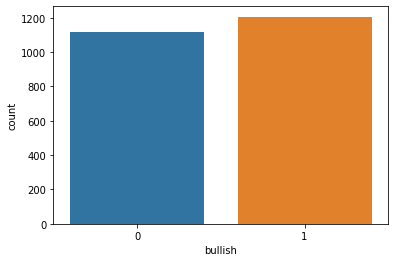

In [15]:
sns.countplot(x='bullish', data=grouped_tweets)

In [16]:
from sklearn.model_selection import train_test_split

features = ['positive_tweets', 'total_tweets']
X_train, X_test, y_train, y_test = train_test_split(grouped_tweets[features], 
                                                    grouped_tweets['bullish'],
                                                    test_size=0.2, 
                                                    random_state=42)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

random_forest_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
random_forest_classifier.fit(X_train, y_train)

y_pred = random_forest_classifier.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred) * 100)

Accuracy score:  61.0752688172043


Using a random forest classifier to predict whether the stock will rise in price based on the number of tweets and positive tweets about them on a particular day results in a 61% accuracy model.
<br>
This model can provide some insights as to how social media sentiments could move prices. We will work on the accuracy again later, but for now we will save this model and use it to analyse tweets.

In [18]:
from joblib import dump

dump(random_forest_classifier, "rand_forest_classifier.joblib")

['rand_forest_classifier.joblib']